In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

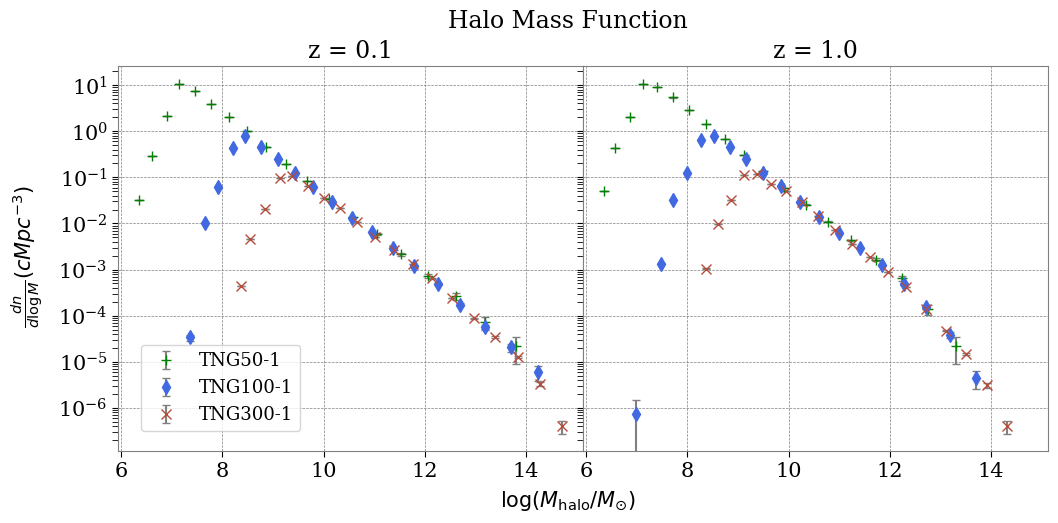

In [4]:
# Plot appearance settings
plt.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.edgecolor': 'grey'
})

#redshifts = {"z=010": 0.1, "z=100": 1.0}
volumes = {"TNG50-1": 51.7, "TNG100-1": 110.7, "TNG300-1": 302.6}

# Snapshot numbers and redshifts
redshifts = {"z05": 0.1, "z1": 1.0}
snapshots = {"z05": 91, "z1": 50}

# Plot settings
plot_colors = {"TNG50-1": "green", "TNG100-1": "royalblue", "TNG300-1": "#B74C3A"}
plot_markers = {"TNG50-1": "+", "TNG100-1": "d", "TNG300-1": "x"}

def running_histogram(X, nBins=100, binSize=None, normFac=None):
    """Adaptive histogram for log-binned data."""
    if binSize is not None:
        nBins = round((X.max() - X.min()) / binSize)

    bins = np.logspace(np.log10(X.min()), np.log10(X.max()), nBins)
    delta = bins[1] - bins[0]

    running_h = []
    bin_centers = []
    raw_counts = []

    for bin in bins:
        binMax = bin + delta
        w = np.where((X >= bin) & (X < binMax))
        count = len(w[0])
        if count:
            running_h.append(count)
            raw_counts.append(count)
            bin_centers.append(np.nanmedian(X[w]))

    running_h = np.array(running_h)
    bin_centers = np.array(bin_centers)
    raw_counts = np.array(raw_counts)

    if normFac is not None:
        running_h = running_h / normFac

    return bin_centers, running_h, raw_counts

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

# Loop over redshifts and simulations
for ax, (z_key, z_value) in zip((ax1, ax2), redshifts.items()):
    snap = snapshots[z_key]
    
    for sim in ["TNG50-1", "TNG100-1", "TNG300-1"]:
        basePath = f"../../../sims.TNG/{sim}/output/"
        halo_mass = il.groupcat.loadHalos(basePath, snap, fields=['Group_M_Crit200']) * 1e10 / 0.6774
        halo_mass = np.log10(halo_mass[halo_mass > 0])

        volume = volumes[sim]
        bins, tng, raw_counts = running_histogram(halo_mass, nBins=20)
        poisson_error = np.sqrt(raw_counts) / (volume ** 3)
        tng = tng / (volume ** 3)

        ax.errorbar(
            bins, tng, yerr=poisson_error,
            label=sim,
            color=plot_colors[sim],
            marker=plot_markers[sim],
            linestyle="",
            markersize=7,
            ecolor="grey",
            capsize=3
        )

    ax.set_title(f"z = {z_value:.1f}", size=17)

# Axis labels
fig.text(0.5, 0.97, "Halo Mass Function", ha="center", va="center", size=17)
fig.text(0.5, 0.01, r"$\log(M_{\mathrm{halo}} / M_{\odot})$", ha="center", va="center", size=15)
fig.text(0.05, 0.5, r"$\frac{dn}{d\log M}(cMpc^{-3})$", ha="center", va="center", rotation="vertical", size=15)

# Legend
ax1.legend(loc="upper left", fontsize=13, frameon=True, bbox_to_anchor=(0.03, 0.3))

# Grid and scale
for ax in (ax1, ax2):
    ax.grid(True, which="major", linestyle="--", linewidth=0.5, color="grey")
    ax.tick_params(axis="both", which="both", length=4)

plt.yscale("log")
fig.savefig("halo_mass_function_comparison.png", bbox_inches="tight", dpi=700)
plt.show()

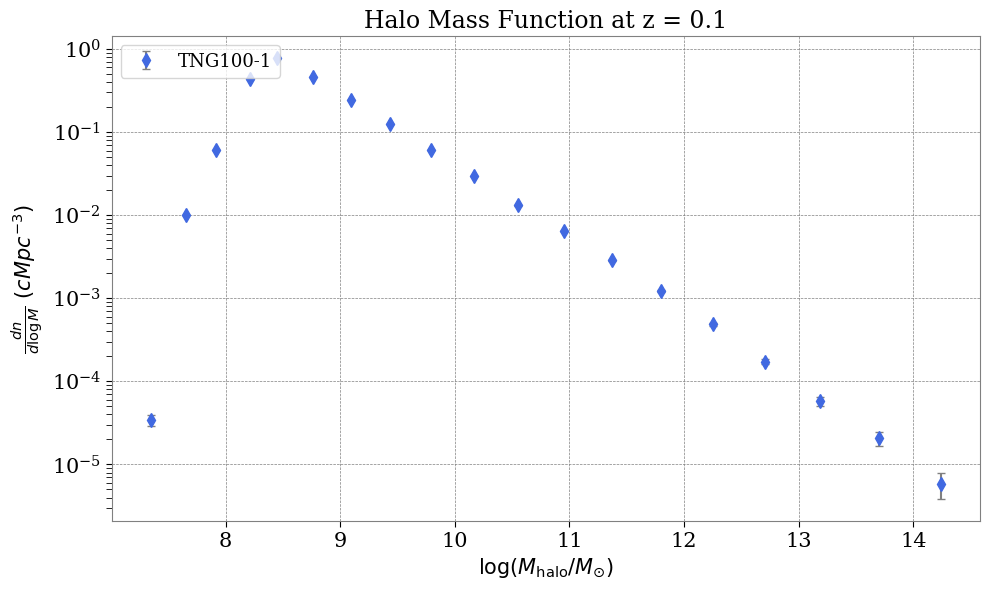

In [6]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over simulations at a single redshift
z_key = list(redshifts.keys())[0]
z_value = redshifts[z_key]
snap = snapshots[z_key]

for sim in ["TNG100-1"]:
    basePath = f"../../../sims.TNG/{sim}/output/"
    halo_mass = il.groupcat.loadHalos(basePath, snap, fields=['Group_M_Crit200']) * 1e10 / 0.6774
    halo_mass = np.log10(halo_mass[halo_mass > 0])

    volume = volumes[sim]
    bins, tng, raw_counts = running_histogram(halo_mass, nBins=20)
    poisson_error = np.sqrt(raw_counts) / (volume ** 3)
    tng = tng / (volume ** 3)

    ax.errorbar(
        bins, tng, yerr=poisson_error,
        label=sim,
        color=plot_colors[sim],
        marker=plot_markers[sim],
        linestyle="",
        markersize=7,
        ecolor="grey",
        capsize=3
    )

# Titles and labels
ax.set_title(f"Halo Mass Function at z = {z_value:.1f}", size=17)
ax.set_xlabel(r"$\log(M_{\mathrm{halo}} / M_{\odot})$", size=15)
ax.set_ylabel(r"$\frac{dn}{d\log M}\ (cMpc^{-3})$", size=15)

# Legend and grid
ax.legend(loc="upper left", fontsize=13, frameon=True)
ax.grid(True, which="major", linestyle="--", linewidth=0.5, color="grey")
ax.tick_params(axis="both", which="both", length=4)
ax.set_yscale("log")

# Save and show
plt.tight_layout()
plt.savefig("halo_mass_function_comparison_single.png", dpi=700, bbox_inches="tight")
plt.show()